### 1. Load Train / Test / Validation Data Files

In [1]:
import numpy as np

In [2]:
train_features_path =  "../feature/BENGALI-RESNET-feature/train_features.npy"
train_names_path = "../feature/BENGALI-RESNET-feature/train_names.npy"
train_labels_path = "../feature/BENGALI-RESNET-feature/train_labels.npy"

test_features_path = "../feature/BENGALI-RESNET-feature/test_features.npy"
test_names_path = "../feature/BENGALI-RESNET-feature/test_names.npy"
test_labels_path = "../feature/BENGALI-RESNET-feature/test_labels.npy"

validation_features_path = "../feature/BENGALI-RESNET-feature/validation_features.npy"
validation_names_path = "../feature/BENGALI-RESNET-feature/validation_names.npy"
validation_labels_path = "../feature/BENGALI-RESNET-feature/validation_labels.npy"

gallery_feature_path = "../feature/BENGALI-RESNET-feature/gallery_features.npy"
gallery_name_path = "../feature/BENGALI-RESNET-feature/gallery_names.npy"

train_features = np.load(train_features_path)
train_names = np.load(train_names_path)
train_labels = np.load(train_labels_path)

test_features = np.load(test_features_path)
test_names = np.load(test_names_path)
test_labels = np.load(test_labels_path)

validation_features = np.load(validation_features_path)
validation_names = np.load(validation_names_path)
validation_labels = np.load(validation_labels_path)

gallery_features = np.load(gallery_feature_path)
gallery_names = np.load(gallery_name_path)

In [3]:
print(train_features.shape)
print(train_labels.shape)
print(train_names.shape)
print(test_features.shape)
print(test_labels.shape)
print(test_names.shape)
print(validation_features.shape)
print(validation_labels.shape)
print(validation_names.shape)
print(gallery_features.shape)
print(gallery_names.shape)

(3200, 2048)
(3200,)
(3200,)
(1100, 2048)
(1100,)
(1100,)
(1100, 2048)
(1100,)
(1100,)
(100, 2048)
(100,)


In [4]:
def find_difference_vector(vector_features, vector_labels, vector_names, gallery_features, gallery_names):
    difference_vectors = []
    difference_names = []
    difference_labels = []

    for gallery_feature, gallery_name in zip(gallery_features, gallery_names):
        curr_difference_name = gallery_name
        curr_difference_feature = []
        curr_difference_label = []
        curr_difference = []
        
        for feature, name, label in zip(vector_features, vector_names, vector_labels):
            # print(f"Gallery Name: {gallery_name}, Name: {name}")
            if gallery_name == name:
                curr_difference_feature.append(feature)
                curr_difference_label.append(label)
        
        if curr_difference_feature:  # Check if the list is not empty
            # Assuming curr_difference_feature, curr_difference_label, and gallery_feature are numpy arrays
            curr_difference_feature = np.array(curr_difference_feature)
            curr_difference_label = np.array(curr_difference_label)
            curr_difference = curr_difference_feature - gallery_feature

            difference_vectors.append(curr_difference)
            difference_names.append(curr_difference_name)
            difference_labels.append(curr_difference_label)
            
    return difference_vectors, difference_names, difference_labels

In [5]:
test_difference_vectors, test_difference_names, test_difference_labels = find_difference_vector(test_features, test_labels, test_names, gallery_features, gallery_names)
train_difference_vectors, train_difference_names, train_difference_labels = find_difference_vector(train_features, train_labels, train_names, gallery_features, gallery_names)
validation_difference_vectors, validation_difference_names, validation_difference_labels = find_difference_vector(validation_features, validation_labels, validation_names, gallery_features, gallery_names)

### 2. Train on ANN

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

In [7]:
train_difference_vectors_flat = np.vstack(train_difference_vectors)
test_difference_vectors_flat = np.vstack(test_difference_vectors)
validation_difference_vectors_flat = np.vstack(validation_difference_vectors)

train_labels = np.vstack(train_labels)
test_labels = np.vstack(test_labels)
validation_labels = np.vstack(validation_labels)

In [8]:
scaler = StandardScaler()
train_difference_vectors_scaled = scaler.fit_transform(train_difference_vectors_flat)
test_difference_vectors_scaled = scaler.transform(test_difference_vectors_flat)
validation_difference_vectors_scaled = scaler.transform(validation_difference_vectors_flat)

In [9]:
def create_model(optimizer='adam', units1=128, units2=64, activation='relu'):
    model = Sequential()
    model.add(Dense(units=units1, input_shape=(train_difference_vectors_flat.shape[1],), activation=activation))
    model.add(Dense(units=units2, activation=activation))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [10]:
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

In [11]:
model.fit(train_difference_vectors_scaled, train_labels)

c:\Users\Andreas Christianto\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


KerasClassifier(
	model=None
	build_fn=<function create_model at 0x000001FCB06511C0>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
	class_weight=None
)

In [12]:
model.model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 270593 (1.03 MB)
Trainable params: 270593 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 3. Hyperparameter Tuning

In [13]:
params = model.get_params()

# Print the parameter keys and values
for key, value in params.items():
    print(f"{key}: {value}")


model: None
build_fn: <function create_model at 0x000001FCB06511C0>
warm_start: False
random_state: None
optimizer: rmsprop
loss: None
metrics: None
batch_size: 32
validation_batch_size: None
verbose: 0
callbacks: None
validation_split: 0.0
shuffle: True
run_eagerly: False
epochs: 10
class_weight: None


In [14]:
param_grid = {'optimizer': ['adam', 'sgd', 'rmsprop'], 'batch_size': [16, 32, 64], 'epochs': [5, 10, 15]}

In [15]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

In [16]:
grid_result = grid.fit(train_difference_vectors_scaled, train_labels)

c:\Users\Andreas Christianto\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


c:\Users\Andreas Christianto\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Andreas Christianto\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Andreas Christianto\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Andreas Christianto\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will b

In [17]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.763437 using {'batch_size': 32, 'epochs': 10, 'optimizer': 'rmsprop'}


### 4. Test

In [18]:
best_model = grid_result.best_estimator_
accuracy = best_model.score(test_difference_vectors_scaled, test_labels)
print(f"Accuracy on the test set: {accuracy}")

Accuracy on the test set: 0.8918181818181818


### 5. ROC Curve

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

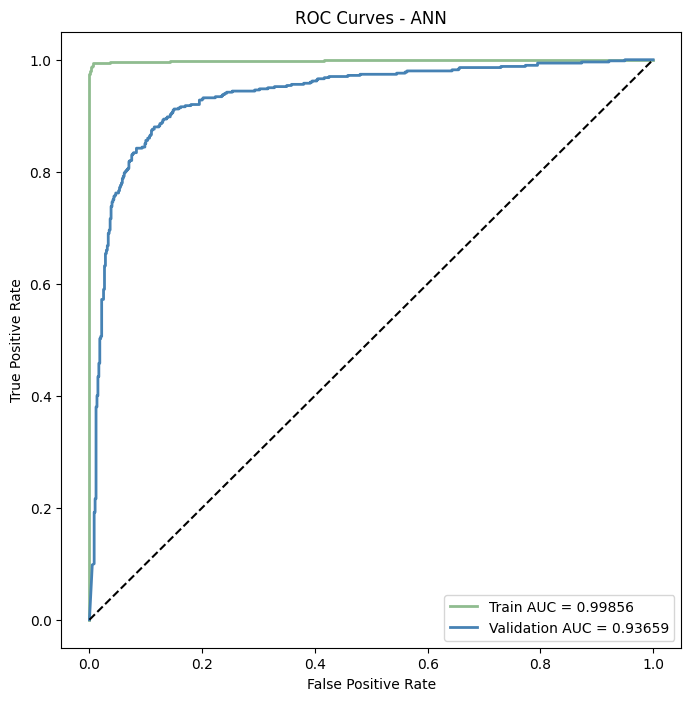

In [20]:
# Get predicted probabilities for each class on each dataset
y_train_prob = best_model.predict_proba(train_difference_vectors_scaled)[:, 1]
y_test_prob = best_model.predict_proba(test_difference_vectors_scaled)[:, 1]
y_val_prob = best_model.predict_proba(validation_difference_vectors_scaled)[:, 1]

fpr_test, tpr_test, _ = roc_curve(test_labels, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)
fpr_train, tpr_train, _ = roc_curve(train_labels, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_val, tpr_val, _ = roc_curve(validation_labels, y_val_prob)
roc_auc_val = auc(fpr_val, tpr_val)

plt.figure(figsize=(8, 8))

plt.plot(fpr_train, tpr_train, color='darkseagreen', lw=2, label=f'Train AUC = {roc_auc_train:.5f}')
plt.plot(fpr_val, tpr_val, color='steelblue', lw=2, label=f'Validation AUC = {roc_auc_val:.5f}')
# plt.plot(fpr_test, tpr_test, color='peru', lw=2, label=f'Test AUC = {roc_auc_test:.5f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - ANN')
plt.legend()
plt.show()

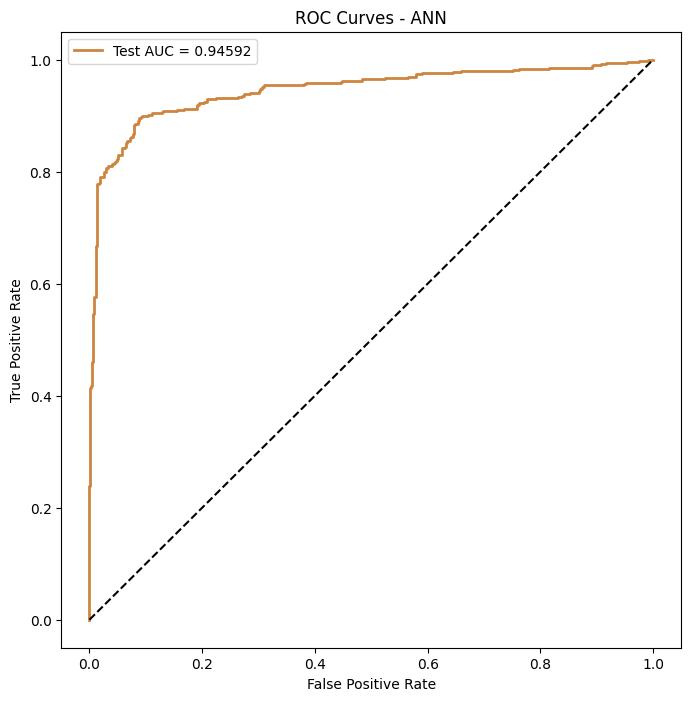

In [21]:
plt.figure(figsize=(8, 8))

# plt.plot(fpr_train, tpr_train, color='darkseagreen', lw=2, label=f'Train AUC = {roc_auc_train:.5f}')
# plt.plot(fpr_val, tpr_val, color='steelblue', lw=2, label=f'Validation AUC = {roc_auc_val:.5f}')
plt.plot(fpr_test, tpr_test, color='peru', lw=2, label=f'Test AUC = {roc_auc_test:.5f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - ANN')
plt.legend()
plt.show()

In [22]:
def find_tpr_at_fpr(fpr, tpr, target_fpr):
    return np.interp(target_fpr, fpr, tpr)

In [23]:
target_fprs = [0.1, 0.01, 0.001]
tpr_at_target_fpr_train = [find_tpr_at_fpr(fpr_train, tpr_train, fpr) for fpr in target_fprs]
tpr_at_target_fpr_test = [find_tpr_at_fpr(fpr_test, tpr_test, fpr) for fpr in target_fprs]
tpr_at_target_fpr_val = [find_tpr_at_fpr(fpr_val, tpr_val, fpr) for fpr in target_fprs]

In [24]:
print("Train")
for tpr, fpr in zip(tpr_at_target_fpr_train, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_train}')

print("Validation")
for tpr, fpr in zip(tpr_at_target_fpr_val, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_val}')

print("Test")
for tpr, fpr in zip(tpr_at_target_fpr_test, target_fprs):
    print(f'TPR at FPR {fpr:.3f}: {tpr:.3f}')
print(f'             AUC: {roc_auc_test}')

Train
TPR at FPR 0.100: 0.996
TPR at FPR 0.010: 0.994
TPR at FPR 0.001: 0.978
             AUC: 0.9985626984126985
Validation
TPR at FPR 0.100: 0.856
TPR at FPR 0.010: 0.216
TPR at FPR 0.001: 0.020
             AUC: 0.9365916666666667
Test
TPR at FPR 0.100: 0.900
TPR at FPR 0.010: 0.576
TPR at FPR 0.001: 0.238
             AUC: 0.9459233333333333
